# Tuango: Steak-house project

You have been hired by Susan Liu, chief Data Scientist at Tuango, as part of the analytics team. Tuango’s business model is similar to that of Groupon, promoting discounted gift certificates that can be used at local or national retailers.

After the success of the Karaoke project the analytics team has been tasked to run and evaluate a new deal for a major high-end steak house. The negotiations with the steak-house were rather difficult. The average price per meal at the restaurant is 600 RMB but Tuango had only been able to negotiate a 25% commission. Susan told you to assume 12 RMB as the cost for each SMS sent to a customer.

For an upcoming meeting with Susan Liu and the CEO of Tuango you were asked to estimate a logistic regression model. The available data has information on customers in a training sample and a test sample. The model estimation completed on time and you are feeling very confident about the meeting. However, the evening before the meeting Susan asks your team to add the following analyses: 

1. Estimate a Neural Network with 1 node in 1 hidden layer and regularization of 0.5 (5 points). Use `tanh` and `lbfgs`.</br>
2. Estimate a Random Forest with 100 trees with 1 feature sampled for consideration for each node split (5 points)</br>
3. Evaluate model performance (profit and ROME) for each of the 3 models to ensure there is no over-fitting using a gains chart (10 points)</br> 

A co-worker told you not to worry because he would run the required analyses on the morning of the meeting. However, he had FAR too much fun at a Karaoke bar the night before and so it is now up to you to add the additional analyses and save the meeting! You have access to a Jupyter notebook file (q3-tuango-shouse.ipynb) that loads the data and generates a report for the logistic regression model. You must add the additional analyses and create projectsions for the remaining 250,000 Tuango customers.

After the meeting Susan asks you to double check if a Neural Network with 1 node in the hidden layer and regularization 0.5 is really the best option. 

4. She suggests using 5-fold cross-validation to evaluate models over a grid with one hidden layer and 1, 2, 3, and 4 nodes and regularization of 0, 0.5, and 1. Use `tanh` and `lbfgs`. Check for overfitting

5. For the Random Forest Susan suggested using 5-fold cross-validation to evaluate models over a grid with 100, 200, and 300 trees and 1, 2, and 3 features sampled. Check for overfitting

The cross validation for both models should evaluate model performance using AUC. Report the best model specification for both NN and RF. 

6. Compare model performance (profit and ROME) to determine which model should be used for targeting. Use the plotting code and labels provided below (10 points)


> Note: Questions repeated in the appropriate spot below

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyrsm as rsm
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# start by loading the `tuango.pkl`
tuango = pd.read_parquet("data/q2-tuango-shouse.parquet")
tuango

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0
2,U22965759,no,0.0,295,1.0,72.900002,59,F,yes,1.0
3,U40811142,no,0.0,277,1.0,40.000000,37,F,yes,0.0
4,U76283952,no,0.0,259,1.0,21.000000,43,F,yes,1.0
...,...,...,...,...,...,...,...,...,...,...
20903,U20475633,no,0.0,118,4.0,18.710001,73,F,no,1.0
20904,U51354565,no,0.0,118,3.0,92.450000,38,F,yes,1.0
20905,U69360423,no,0.0,117,4.0,51.140000,30,F,yes,0.0
20906,U48889214,no,0.0,117,4.0,162.110006,42,F,no,1.0


In [4]:
rsm.md("data/q2-tuango-shouse_description.md")

# Tuango: Targeting Mobile App Push Messages

This file contains information about the test only

## Variable Names and Descriptions
* userid: Unique user ID

**Response to the customized push message**
* buyer: Did the customer buy the Karaoke deal? ("yes" or "no")
* ordersize: Number of 30-minute Karaoke sessions the customer purchased

**Recency, Frequency, and Monetary variables**
* recency: Days since last purchase of a deal (before the Karaoke deal offer)
* frequency: Number of deals purchased during the one year period before the Karaoke deal offer
* monetary: Average amount spent per order (in RMB) during the one year period before the Karaoke deal offer

**Other variables in the dataset**
* age: Age of the customer
* gender: Gender identity of the customer (M = male, F = female, O = Other or unknown)
* music: Customer made a purchase in the music category during the one-year period before the Karaoke deal offer ("no" or "yes")
* test: Splits the dataset into test (1) and rollout (0) data
* training: Splits the dataset into training (1) and test (0) data. This variable will not be used in this assignment

Proportion of customers that responded (i.e., bought the deal) after the push message

In [5]:
pd.crosstab(index=tuango.buyer, columns="fraction", normalize="columns")

col_0,fraction
buyer,
yes,0.096614
no,0.903386


In [6]:
pd.crosstab(index=tuango.buyer, columns=tuango.training, normalize="columns")

training,0.0,1.0
buyer,,
yes,0.094707,0.097431
no,0.905293,0.902569


In [7]:
# Create a column containing an integer when buyer == "yes"
tuango["buyer_yes"] = rsm.ifelse(tuango.buyer == "yes", 1, 0)

**What is the breakeven response rate?**

In [8]:
mcost = 12  # marginal cost to offer the deal
margin = 600 * 0.25  # sales revenue (600) * Tuango margin
nr_cust = 250000  # Remaining number of customers
breakeven = mcost / margin
breakeven

0.08

In [9]:
mcost / margin

0.08

The projected (a) profit in RMB and (b) return on marketing expenditures if we offer the deal to all 250,000 remaining customers

In [10]:
# Add an `smsto_all` variable ...
tuango["smsto_all"] = True

In [11]:
dat = tuango.query("training == 0")
perc_sms = dat.smsto_all.mean()
nr_sms = nr_cust * perc_sms
resp_rate = dat.loc[dat.smsto_all, "buyer_yes"].mean()
nr_resp = nr_sms * resp_rate
sms_cost = mcost * nr_sms
profit_nt = margin * nr_resp - sms_cost
ROME_nt = profit_nt / sms_cost

result = f"""
- If Tuango sends an SMS to all {nr_sms:,.0f} customers the response rate is predicted to be {(100 * resp_rate):.2f}% or {nr_resp:.0f} buyers 
- The expected profit is RMB{profit_nt:,.0f}. 
- The sms cost is estimated to be RMB{sms_cost:,.0f} with a ROME of {(100 * ROME_nt):.2f}%
"""
print(result)


- If Tuango sends an SMS to all 250,000 customers the response rate is predicted to be 9.47% or 23677 buyers 
- The expected profit is RMB551,499. 
- The sms cost is estimated to be RMB3,000,000 with a ROME of 18.38%



Estimate a logistic regression model

In [12]:
evar = tuango.loc[:, "recency":"gender"].columns.to_list()
evar

['recency', 'frequency', 'monetary', 'age', 'gender']

In [13]:
lr = rsm.model.logistic(
    data={"tuango": tuango.query("training == 1")},
    rvar="buyer",
    lev="yes",
    evar=evar
)
lr.summary()

Logistic regression (GLM)
Data                 : tuango
Response variable    : buyer
Level                : yes
Explanatory variables: recency, frequency, monetary, age, gender
Null hyp.: There is no effect of x on buyer
Alt. hyp.: There is an effect of x on buyer

              OR     OR%  coefficient  std.error  z.value p.value     
Intercept  0.079  -92.1%        -2.54      0.101  -25.096  < .001  ***
gender[F]  1.815   81.5%         0.60      0.065    9.114  < .001  ***
gender[O]  1.136   13.6%         0.13      0.148    0.862   0.389     
recency    0.999   -0.1%        -0.00      0.000   -2.570    0.01    *
frequency  1.108   10.8%         0.10      0.012    8.631  < .001  ***
monetary   1.002    0.2%         0.00      0.000   10.592  < .001  ***
age        0.988   -1.2%        -0.01      0.002   -7.304  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squared (McFadden): 0.036
Pseudo R-squared (McFadden adjusted): 0.035
Area under the RO Curv

In [14]:
tuango["pred_logit"] = lr.predict(tuango)["prediction"]

**Offer the deal only to those customers with a response rate that is greater than the breakeven response rate** 

We first need to create a `smsto_logit` variable

`smsto_logit = predict_logit > breakeven`

In [15]:
# Add an `smsto_logit` variable ...
tuango["smsto_logit"] = tuango.pred_logit > breakeven

In [16]:
dat = tuango.query("training == 0")
perc_sms = dat.smsto_logit.mean()
nr_sms = nr_cust * perc_sms
resp_rate = dat.loc[dat.smsto_logit, "buyer_yes"].mean()
nr_resp = nr_sms * resp_rate
sms_cost = mcost * nr_sms
profit_logit = margin * nr_resp - sms_cost
ROME_logit = profit_logit / sms_cost

result = f"""
- Based on logistic regression the number of customers Tuango should sms is {nr_sms:,.0f} ({(100 * perc_sms):,.2f}%
- The response rate for the selected customers is predicted to be ({(100 *resp_rate):.2f}%) or {nr_resp:,.0f} buyers 
- The expected profit is ${profit_logit:,.0f}
- The sms cost is estimated to be RMB{sms_cost:,.0f} with a ROME of {(100 * ROME_logit):.2f}%
"""

print(result)


- Based on logistic regression the number of customers Tuango should sms is 147,800 (59.12%
- The response rate for the selected customers is predicted to be (12.27%) or 18,136 buyers 
- The expected profit is $946,827
- The sms cost is estimated to be RMB1,773,597 with a ROME of 53.38%



A co-worker told you not to worry because he would run the required analyses on the morning of the meeting. However, he had FAR too much fun at a Karaoke bar the night before and so it is now up to you to add the additional analyses and save the meeting! You have access to a Jupyter notebook file (q3-tuango-shouse.ipynb) that loads the data and generates a report for the logistic regression model. You must add the additional analyses and create projectsions for the remaining 250,000 Tuango customers.

---------------------------------------------------------------
### Put all new analyses below this line
---------------------------------------------------------------

In [17]:
evar = ["recency", "frequency", "monetary", "age", "gender"]

#### 1. Estimate a Neural Network with 1 node in 1 hidden layer and regularization of 0.5. Use `tanh` and `lbfgs`.</br>

In [18]:
rsm.model.mlp?

Init signature:
rsm.model.mlp(
    data: pandas.core.frame.DataFrame | polars.dataframe.frame.DataFrame | dict[str, pandas.core.frame.DataFrame | polars.dataframe.frame.DataFrame],
    rvar: Optional[str] = None,
    lev: Optional[str] = None,
    evar: Optional[list[str]] = None,
    hidden_layer_sizes: tuple = (5,),
    activation: Literal['identity', 'logistic', 'tanh', 'relu'] = 'tanh',
    solver: Literal['lbfgs', 'sgd', 'adam'] = 'lbfgs',
    alpha: float = 0.0001,
    batch_size: float | str = 'auto',
    learning_rate_init: float = 0.001,
    max_iter: int = 10000,
    random_state: int = 1234,
    mod_type: Literal['regression', 'classification'] = 'classification',
    **kwargs,
) -> None
Docstring:     
Initialize Multi-layer Perceptron (NN) model

Parameters
----------
data: pandas DataFrame; dataset
lev: String; name of the level in the response variable
rvar: String; name of the column to be used as the response variable
evar: List of strings; contains the names of the co

In [19]:
clf1 = rsm.model.mlp(
    data={"tuango": tuango.query("training == 1")},
    rvar="buyer",
    lev="yes",
    evar=evar,
    hidden_layer_sizes=(1,),
    mod_type="classification",
    alpha=0.5,
    activation = 'tanh',
    solver = 'lbfgs'
)
clf1.summary()

Multi-layer Perceptron (NN)
Data                 : tuango
Response variable    : buyer
Level                : yes
Explanatory variables: recency, frequency, monetary, age, gender
Model type           : classification
Nr. of features      : (5, 6)
Nr. of observations  : 14,636
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.5
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 10000
random_state         : 1234
AUC                  : 0.633

Raw data             :
 recency  frequency  monetary  age gender
     297        8.0 39.799999   80      M
     295        1.0 72.900002   59      F
     259        1.0 21.000000   43      F
     243        1.0 19.900000   19      M
     216        1.0 40.000000   38      F

Estimation data      :
 recency  frequency  monetary       age  gender_F  gender_O
3.043287   2.502123 -0.313856  1.863260     False     False
3.017940  -0.780890 -0.006706  0.706537      Tru

In [20]:
tuango["pred_nn"] = clf1.predict(tuango)["prediction"]

#### 2. Estimate a Random Forest with 100 trees with 1 feature sampled for consideration for each node split</br>

In [21]:
rf = rsm.model.rforest(
    data={"tuango": tuango.query("training == 1")},
    rvar="buyer",
    lev="yes",
    evar=evar, 
    mod_type ='classification',
    n_estimators = 100,
    min_samples_leaf = 1
)
rf.summary()

Random Forest
Data                 : tuango
Response variable    : buyer
Level                : yes
Explanatory variables: recency, frequency, monetary, age, gender
OOB                  : True
Model type           : classification
Nr. of features      : (5, 7)
Nr. of observations  : 14,636
max_features         : sqrt (2)
n_estimators         : 100
min_samples_leaf     : 1
random_state         : 1234
AUC                  : 0.64

Estimation data      :
 recency  frequency  monetary  age  gender_M  gender_F  gender_O
     297        8.0 39.799999   80      True     False     False
     295        1.0 72.900002   59     False      True     False
     259        1.0 21.000000   43     False      True     False
     243        1.0 19.900000   19      True     False     False
     216        1.0 40.000000   38     False      True     False


In [22]:
tuango["pred_rf"] = rf.predict(tuango)["prediction"]

In [23]:
tuango.head()

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,buyer_yes,smsto_all,pred_logit,smsto_logit,pred_nn,pred_rf
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0,0,True,0.124875,True,0.124075,0.14
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0,0,True,0.054452,False,0.050858,0.00
2,U22965759,no,0.0,295,1.0,72.900002,59,F,yes,1.0,0,True,0.066288,False,0.065587,0.10
3,U40811142,no,0.0,277,1.0,40.000000,37,F,yes,0.0,0,True,0.079522,False,0.079977,0.09
4,U76283952,no,0.0,259,1.0,21.000000,43,F,yes,1.0,0,True,0.072467,False,0.071693,0.06


#### 3. Evaluate model performance (profit and ROME) for each of the 3 models to ensure there is no over-fitting using a gains chart</br> 

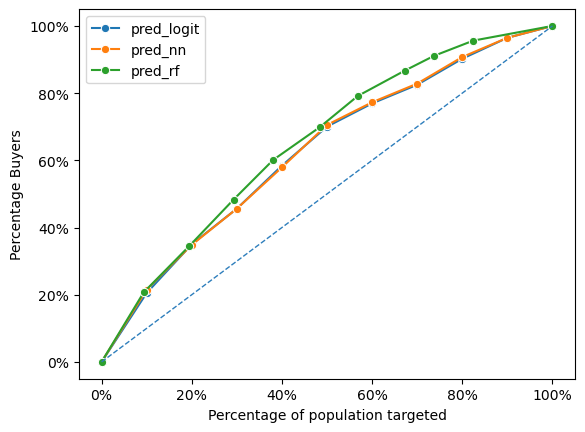

In [25]:
fig = rsm.gains_plot(tuango[tuango['training']==0], 'buyer', 'yes', ["pred_logit", "pred_nn", "pred_rf"])

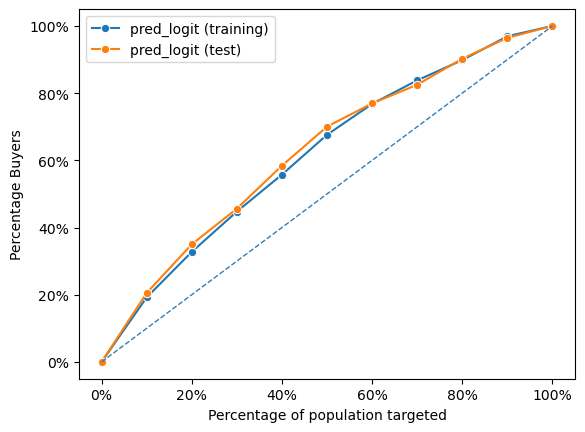

In [26]:
dct = {
    "training": tuango[tuango['training']==1],
    "test": tuango[tuango['training']==0],
}
fig = rsm.gains_plot(dct, "buyer", 'yes', "pred_logit")

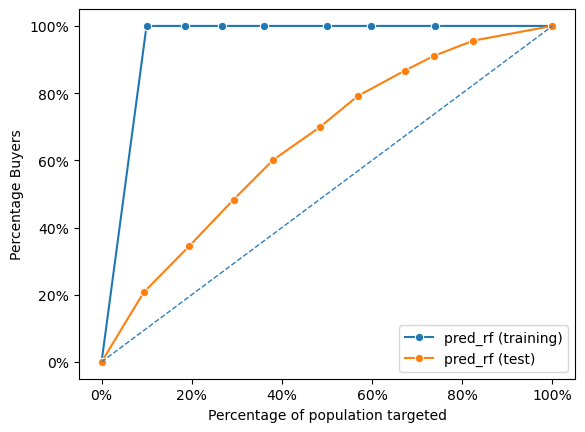

In [27]:
fig = rsm.gains_plot(dct, "buyer", 'yes', "pred_rf")

RF is overfitting

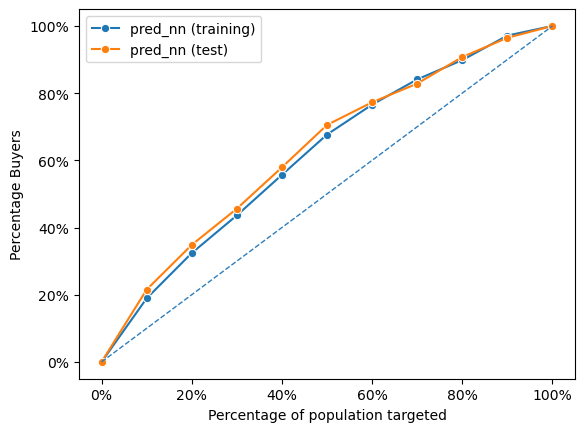

In [28]:
fig = rsm.gains_plot(dct, "buyer", 'yes', "pred_nn")

4. She suggests using 5-fold cross-validation to evaluate models over a grid with one hidden layer and 1, 2, 3, and 4 nodes and regularization of 0, 0.5, and 1. Use `tanh` and `lbfgs`. Check for overfitting (5 points) 

5. For the Random Forest Susan suggested using 5-fold cross-validation to evaluate models over a grid with 100, 200, and 300 trees and 1, 2, and 3 features sampled. Check for overfitting (5 points) 

The cross validation for both models should evaluate model performance using AUC. Report the best model specification for both NN and RF. 

6. Compare model performance (profit and ROME) to determine which model should be used for targeting. Use the plotting code and labels provided below (10 points)


In [29]:
param_grid = {
    'hidden_layer_sizes': [(1,), (2,), (3,), (4,)],  # One hidden layer with 1-4 nodes
    'alpha': [0, 0.5, 1],  # Regularization strength
    'activation': ['tanh'],  # Activation function for the hidden layer
    'solver': ['lbfgs']  # Solver for weight optimization
}
scoring = {"AUC": "roc_auc"}
# Set up GridSearchCV
clf_cv = GridSearchCV(
    clf1.fitted, param_grid, scoring=scoring, cv=5, n_jobs=4, refit='AUC', verbose=5 
)

In [30]:
clf1.data_onehot.mean().round(3)

recency      0.000
frequency    0.000
monetary    -0.000
age          0.000
gender_F     0.599
gender_O     0.053
dtype: float64

In [31]:
clf_cv.fit(clf1.data_onehot, clf1.data.buyer)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', alpha=0.5,
                                     hidden_layer_sizes=(1,), max_iter=10000,
                                     random_state=1234, solver='lbfgs'),
             n_jobs=4,
             param_grid={'activation': ['tanh'], 'alpha': [0, 0.5, 1],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,)],
                         'solver': ['lbfgs']},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [34]:
best = clf_cv.best_params_

In [35]:
clf_cv = rsm.model.mlp(
    data={"tuango": tuango.query("training == 1")},
    rvar="buyer",
    lev="yes",
    evar=evar,
    hidden_layer_sizes=best['hidden_layer_sizes'],
    mod_type="classification",
    alpha=best['alpha'],
    activation = 'tanh',
    solver = 'lbfgs'
)
clf_cv.summary()

Multi-layer Perceptron (NN)
Data                 : tuango
Response variable    : buyer
Level                : yes
Explanatory variables: recency, frequency, monetary, age, gender
Model type           : classification
Nr. of features      : (5, 6)
Nr. of observations  : 14,636
Hidden_layer_sizes   : (3,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 10000
random_state         : 1234
AUC                  : 0.722

Raw data             :
 recency  frequency  monetary  age gender
     297        8.0 39.799999   80      M
     295        1.0 72.900002   59      F
     259        1.0 21.000000   43      F
     243        1.0 19.900000   19      M
     216        1.0 40.000000   38      F

Estimation data      :
 recency  frequency  monetary       age  gender_F  gender_O
3.043287   2.502123 -0.313856  1.863260     False     False
3.017940  -0.780890 -0.006706  0.706537      True 

In [36]:
tuango["pred_nn_cv"] = clf_cv.predict(tuango)["prediction"]

5. For the Random Forest Susan suggested using 5-fold cross-validation to evaluate models over a grid with 100, 200, and 300 trees and 1, 2, and 3 features sampled. Check for overfitting 

Tuning RF

In [39]:
param_grid = {'n_estimators':[100, 200, 300],
              'min_samples_leaf':[1, 2, 3]}

scoring = {'AUC':'roc_auc'}

rf_cv = GridSearchCV(
    rf.fitted, param_grid, scoring=scoring, cv=5, n_jobs=4, refit='AUC', verbose=5 
)

In [40]:
rf_cv.fit(rf.data_onehot, rf.data.buyer)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=1234),
             n_jobs=4,
             param_grid={'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 200, 300]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [41]:
rf_cv.best_params_

{'min_samples_leaf': 3, 'n_estimators': 300}

In [42]:
rf_cv = rsm.model.rforest(
    data={"tuango": tuango.query("training == 1")},
    rvar="buyer",
    lev="yes",
    evar=evar, 
    mod_type ='classification',
    n_estimators = 300,
    min_samples_leaf = 3
)
rf_cv.summary()

Random Forest
Data                 : tuango
Response variable    : buyer
Level                : yes
Explanatory variables: recency, frequency, monetary, age, gender
OOB                  : True
Model type           : classification
Nr. of features      : (5, 7)
Nr. of observations  : 14,636
max_features         : sqrt (2)
n_estimators         : 300
min_samples_leaf     : 3
random_state         : 1234
AUC                  : 0.672

Estimation data      :
 recency  frequency  monetary  age  gender_M  gender_F  gender_O
     297        8.0 39.799999   80      True     False     False
     295        1.0 72.900002   59     False      True     False
     259        1.0 21.000000   43     False      True     False
     243        1.0 19.900000   19      True     False     False
     216        1.0 40.000000   38     False      True     False


In [44]:
tuango.head(2)

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,buyer_yes,smsto_all,pred_logit,smsto_logit,pred_nn,pred_rf,pred_nn_cv,pred_rf_cv
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0,0,True,0.124875,True,0.124075,0.14,0.197967,0.154083
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0,0,True,0.054452,False,0.050858,0.00,0.017151,0.009637


In [43]:
tuango["pred_rf_cv"] = rf_cv.predict(tuango)["prediction"]

In [46]:
tuango["smsto_nn"] = tuango.pred_nn > breakeven
tuango["smsto_rf"] = tuango.pred_rf > breakeven
tuango["smsto_nn_cv"] = tuango.pred_nn_cv > breakeven
tuango["smsto_rf_cv"] = tuango.pred_rf_cv > breakeven


In [47]:
dat = tuango.query("training == 0")
perc_sms = dat.smsto_logit.mean()
nr_sms = nr_cust * perc_sms
resp_rate = dat.loc[dat.smsto_nn, "buyer_yes"].mean()
nr_resp = nr_sms * resp_rate
sms_cost = mcost * nr_sms
profit_nn = margin * nr_resp - sms_cost
ROME_nn = profit_nn / sms_cost

result = f"""
- Based on logistic regression the number of customers Tuango should sms is {nr_sms:,.0f} ({(100 * perc_sms):,.2f}%
- The response rate for the selected customers is predicted to be ({(100 *resp_rate):.2f}%) or {nr_resp:,.0f} buyers 
- The expected profit is ${profit_logit:,.0f}
- The sms cost is estimated to be RMB{sms_cost:,.0f} with a ROME of {(100 * ROME_logit):.2f}%
"""

print(result)


- Based on logistic regression the number of customers Tuango should sms is 147,800 (59.12%
- The response rate for the selected customers is predicted to be (12.30%) or 18,186 buyers 
- The expected profit is $946,827
- The sms cost is estimated to be RMB1,773,597 with a ROME of 53.38%



In [48]:
dat = tuango.query("training == 0")
perc_sms = dat.smsto_logit.mean()
nr_sms = nr_cust * perc_sms
resp_rate = dat.loc[dat.smsto_rf, "buyer_yes"].mean()
nr_resp = nr_sms * resp_rate
sms_cost = mcost * nr_sms
profit_rf = margin * nr_resp - sms_cost
ROME_rf = profit_rf / sms_cost

result = f"""
- Based on logistic regression the number of customers Tuango should sms is {nr_sms:,.0f} ({(100 * perc_sms):,.2f}%
- The response rate for the selected customers is predicted to be ({(100 *resp_rate):.2f}%) or {nr_resp:,.0f} buyers 
- The expected profit is ${profit_logit:,.0f}
- The sms cost is estimated to be RMB{sms_cost:,.0f} with a ROME of {(100 * ROME_logit):.2f}%
"""

print(result)


- Based on logistic regression the number of customers Tuango should sms is 147,800 (59.12%
- The response rate for the selected customers is predicted to be (14.53%) or 21,469 buyers 
- The expected profit is $946,827
- The sms cost is estimated to be RMB1,773,597 with a ROME of 53.38%



In [49]:
dat = tuango.query("training == 0")
perc_sms = dat.smsto_logit.mean()
nr_sms = nr_cust * perc_sms
resp_rate = dat.loc[dat.smsto_rf_cv, "buyer_yes"].mean()
nr_resp = nr_sms * resp_rate
sms_cost = mcost * nr_sms
profit_rfcv = margin * nr_resp - sms_cost
ROME_rfcv = profit_rfcv / sms_cost

result = f"""
- Based on logistic regression the number of customers Tuango should sms is {nr_sms:,.0f} ({(100 * perc_sms):,.2f}%
- The response rate for the selected customers is predicted to be ({(100 *resp_rate):.2f}%) or {nr_resp:,.0f} buyers 
- The expected profit is ${profit_logit:,.0f}
- The sms cost is estimated to be RMB{sms_cost:,.0f} with a ROME of {(100 * ROME_logit):.2f}%
"""

print(result)


- Based on logistic regression the number of customers Tuango should sms is 147,800 (59.12%
- The response rate for the selected customers is predicted to be (14.81%) or 21,894 buyers 
- The expected profit is $946,827
- The sms cost is estimated to be RMB1,773,597 with a ROME of 53.38%



In [50]:
dat = tuango.query("training == 0")
perc_sms = dat.smsto_logit.mean()
nr_sms = nr_cust * perc_sms
resp_rate = dat.loc[dat.smsto_nn_cv, "buyer_yes"].mean()
nr_resp = nr_sms * resp_rate
sms_cost = mcost * nr_sms
profit_nncv = margin * nr_resp - sms_cost
ROME_nncv = profit_nncv / sms_cost

result = f"""
- Based on logistic regression the number of customers Tuango should sms is {nr_sms:,.0f} ({(100 * perc_sms):,.2f}%
- The response rate for the selected customers is predicted to be ({(100 *resp_rate):.2f}%) or {nr_resp:,.0f} buyers 
- The expected profit is ${profit_logit:,.0f}
- The sms cost is estimated to be RMB{sms_cost:,.0f} with a ROME of {(100 * ROME_logit):.2f}%
"""

print(result)


- Based on logistic regression the number of customers Tuango should sms is 147,800 (59.12%
- The response rate for the selected customers is predicted to be (14.39%) or 21,276 buyers 
- The expected profit is $946,827
- The sms cost is estimated to be RMB1,773,597 with a ROME of 53.38%



## Performance bar charts

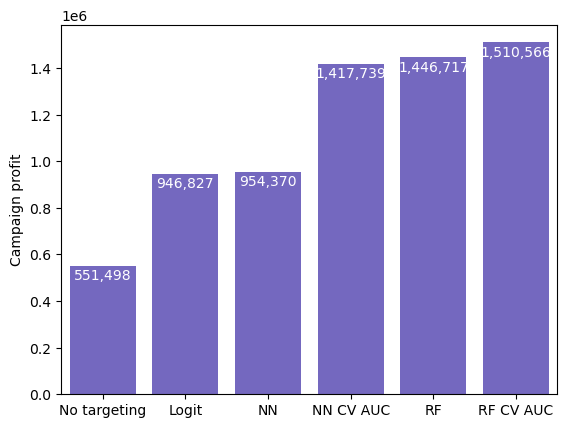

In [51]:
# Updating profit and ROME plots:
dat = pd.DataFrame(
    {
        "name": [
            "No targeting",
            "Logit",
            "NN",
            "NN CV AUC",
            "RF",
            "RF CV AUC"
        ],
        "Profit": [
            profit_nt,
            profit_logit,
            profit_nn,
            profit_nncv,
            profit_rf,
            profit_rfcv

        ],
        "ROME": [ROME_nt, ROME_logit, ROME_nn, ROME_nncv, ROME_rf, ROME_rfcv],
    }
)

plt.clf()
fig = sns.barplot(x="name", y="Profit", color="slateblue", data=dat)
fig.set(xlabel="", ylabel="Campaign profit")
for index, row in dat.iterrows():
    fig.text(
        row.name, row.Profit - 60_000, f"{int(row.Profit):,}", ha="center", color="white"
    )
plt.show()

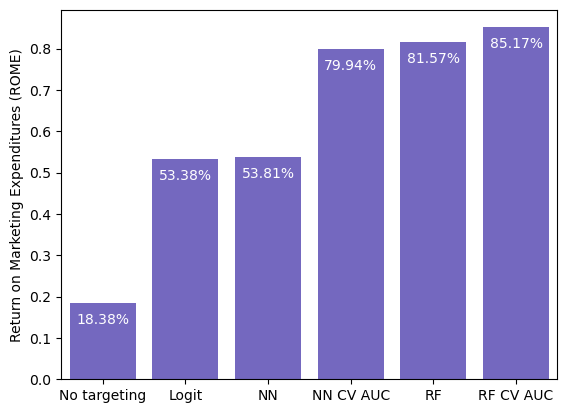

In [52]:
plt.clf()
fig = sns.barplot(x="name", y="ROME", color="slateblue", data=dat)
fig.set(xlabel="", ylabel="Return on Marketing Expenditures (ROME)")
for index, row in dat.iterrows():
    fig.text(
        row.name,
        row.ROME - 0.05,
        f"{round((100*row.ROME), 2):,}%",
        ha="center",
        color="white",
    )
plt.show()